In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sqlalchemy import create_engine
import numpy as np

In [3]:
student_df = pd.read_csv("data.csv",delimiter=';')
print(student_df)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   16       U     LE3       T     4     3   teacher  services   
1       GP   M   18       U     LE3       T     1     1     other     other   
2       GP   M   17       R     LE3       A     4     4   teacher     other   
3       GP   F   15       U     LE3       T     3     2  services     other   
4       GP   M   16       U     GT3       T     2     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
311     GP   M   15       U     LE3       A     2     1  services     other   
312     GP   F   17       U     GT3       A     4     4     other   teacher   
313     GP   F   15       U     GT3       T     4     4   teacher   teacher   
314     MS   F   19       R     GT3       T     2     3  services     other   
315     GP   F   16       U     GT3       T     4     3     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

Model                                                  RandomForestRegressor
Best Params                {'criterion': 'squared_error', 'max_leaf_nodes...
Best Model                 (DecisionTreeRegressor(max_features=1.0, max_l...
Best Score                                                         -2.701727
R2 Score Tuned                                                      0.911957
Mean Squared Error Tuned                                            1.565153
Mean Absolute Error Tuned                                           0.912827


KeyError: "None of [Index(['R2 Score'], dtype='object')] are in the [index]"

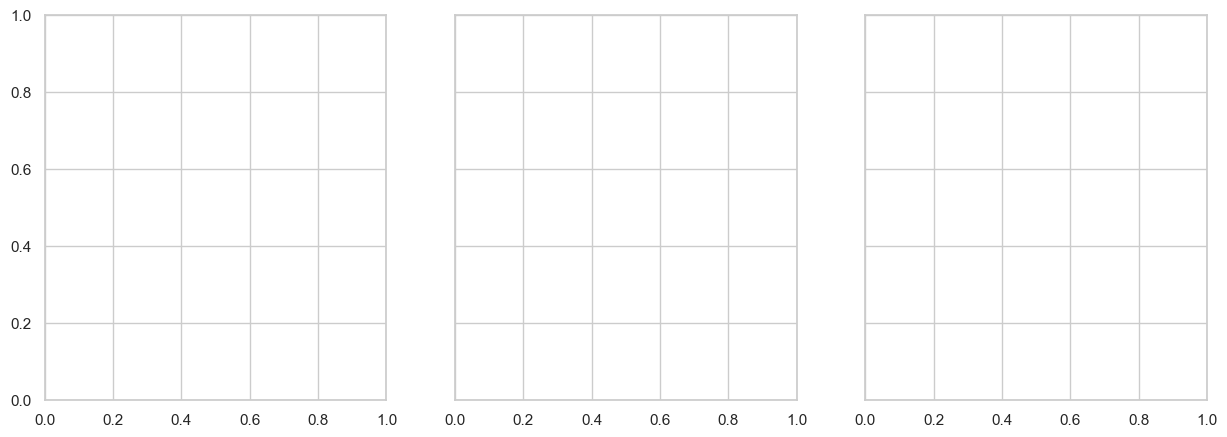

In [12]:
def process_and_evaluate_dataset(data, models, param_grids):
    # Select features and target variable
    X = data.drop("G3", axis=1)
    y = data["G3"]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Preprocess the data
    X_train_preprocessed = pd.get_dummies(X_train, drop_first=True)
    X_test_preprocessed = pd.get_dummies(X_test, drop_first=True)

    results_list = []

    for model_name, model in models.items():
        # Tune hyperparameters
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_

        # Evaluate tuned model
        y_pred_tuned = best_model.predict(X_test_preprocessed)
        mse_tuned = mean_squared_error(y_test, y_pred_tuned)
        r2_tuned = r2_score(y_test, y_pred_tuned)
        mean_absolute_error_tuned = mean_absolute_error(y_test, y_pred_tuned)

        # Store results in a DataFrame
        results_df = pd.DataFrame({
            'Model': [model_name],
            'Best Params': [best_params],
            'Best Model': [best_model],
            'Best Score': [best_score],
            'R2 Score Tuned': [r2_tuned],
            'Mean Squared Error Tuned': [mse_tuned],
            'Mean Absolute Error Tuned': [mean_absolute_error_tuned]
        })

        results_list.append(results_df)

        # Visualize evaluation metrics
        '''fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(['R2 Score', 'Mean Squared Error', 'Mean Absolute Error'],
               [r2_tuned, mse_tuned, mean_absolute_error_tuned])
        ax.set_ylabel('Metrics')
        ax.set_title(f'{model_name} - Tuned Model Evaluation Metrics')
        plt.show()'''

        untuned_results_transposed = results_df.set_index('Model').transpose()
        print(untuned_results_transposed)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

        # Plot R2 Score for each model
        sns.barplot(data=untuned_results_transposed.loc[['R2 Score']], ax=axes[0], color='blue')
        axes[0].set_title('R2 Score')
        axes[0].set_ylabel('R2 Score')

        # Plot MSE for each model
        sns.barplot(data=untuned_results_transposed.loc[['Mean Squared Error']], ax=axes[1], color='green')
        axes[1].set_title('Mean Squared Error')
        axes[1].set_ylabel('Mean Squared Error')

        # Plot MAE for each model
        sns.barplot(data=untuned_results_transposed.loc[['Mean Absolute Error']], ax=axes[2], color='red')
        axes[2].set_title('Mean Absolute Error')
        axes[2].set_ylabel('Mean Absolute Error')

        # Uncomment the next line to display the plots
        plt.show()

        # Evaluate untuned model
        model.fit(X_train_preprocessed, y_train)
        y_pred_untuned = model.predict(X_test_preprocessed)
        mse_untuned = mean_squared_error(y_test, y_pred_untuned)
        r2_untuned = r2_score(y_test, y_pred_untuned)
        mean_absolute_error_untuned = mean_absolute_error(y_test, y_pred_untuned)

        # Store untuned results in the DataFrame
        untuned_results_df = pd.DataFrame({
            'Model': [model_name],
            'R2 Score Untuned': [r2_untuned],
            'Mean Squared Error Untuned': [mse_untuned],
            'Mean Absolute Error Untuned': [mean_absolute_error_untuned]
        })

        results_list.append(untuned_results_df)

    # Combine all DataFrames into a single result DataFrame
    final_result_df = pd.concat(results_list, ignore_index=True)
    return final_result_df
svr_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf']
}
#svr_model = SVR()


ridge_param_grid = {'alpha': [0.1, 1, 10]} #default=1.0
#ridge_model = Ridge()

randomForest_param_grid={
    'n_estimators':[100,200,500],  #default 100
    'criterion':['squared_error','absolute_error'], #default squared_error
    'min_samples_split':[2,3,4,5], #default 2
    'min_samples_leaf':[1,2,4,5], #default=1
    'max_leaf_nodes':[4,10,20,50,None] #default=None
}
#randomForest_model=RandomForestRegressor()
# Dictionary of models
models_selected = {
    'RandomForestRegressor': RandomForestRegressor(),
    'Linear SVR': SVR(),
    'Ridge Regressor': Ridge()
}

# Dictionary of param grids
param_grids = {
    'RandomForestRegressor': randomForest_param_grid, 
    'Linear SVR': svr_param_grid,
    'Ridge Regressor': ridge_param_grid
}

# Example usage
df1 = student_df.copy()
results_df1 = process_and_evaluate_dataset(df1, models_selected, param_grids)
print("Results for Dataset 1:")
print(results_df1)
selection = ["G1", "G2", "G3"]
df2 = df1[selection].copy()
results_df2 = process_and_evaluate_dataset(df2, models_selected, param_grids)
print("Results for Dataset 2:")
print(results_df2)
df3=df1["Dalc",""]


In [ ]:
# Assuming you have a list of DataFrames named dataset_list
# Assuming you have a list of results DataFrames named results_list

# Iterate over datasets and results
for dataset_name, results_df in zip(dataset_list, results_list):
    # Separate tuned and untuned results
    tuned_results = results_df[['Model', 'R2 Score Tuned', 'Mean Squared Error Tuned', 'Mean Absolute Error Tuned']]
    untuned_results = results_df[['Model', 'R2 Score Untuned', 'Mean Squared Error Untuned', 'Mean Absolute Error Untuned']]

    # Iterate over metrics
    metrics = ['R2 Score', 'Mean Squared Error', 'Mean Absolute Error']
    for metric in metrics:
        # Create a grouped bar plot for tuned results
        plt.figure(figsize=(14, 10))
        sns.barplot(x='Model', y=f'{metric} Tuned', data=tuned_results)
        plt.title(f'Tuned Model Evaluation Metrics - {dataset_name} - {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.show()

        # Create a grouped bar plot for untuned results
        plt.figure(figsize=(14, 10))
        sns.barplot(x='Model', y=f'{metric} Untuned', data=untuned_results)
        plt.title(f'Untuned Model Evaluation Metrics - {dataset_name} - {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.show()


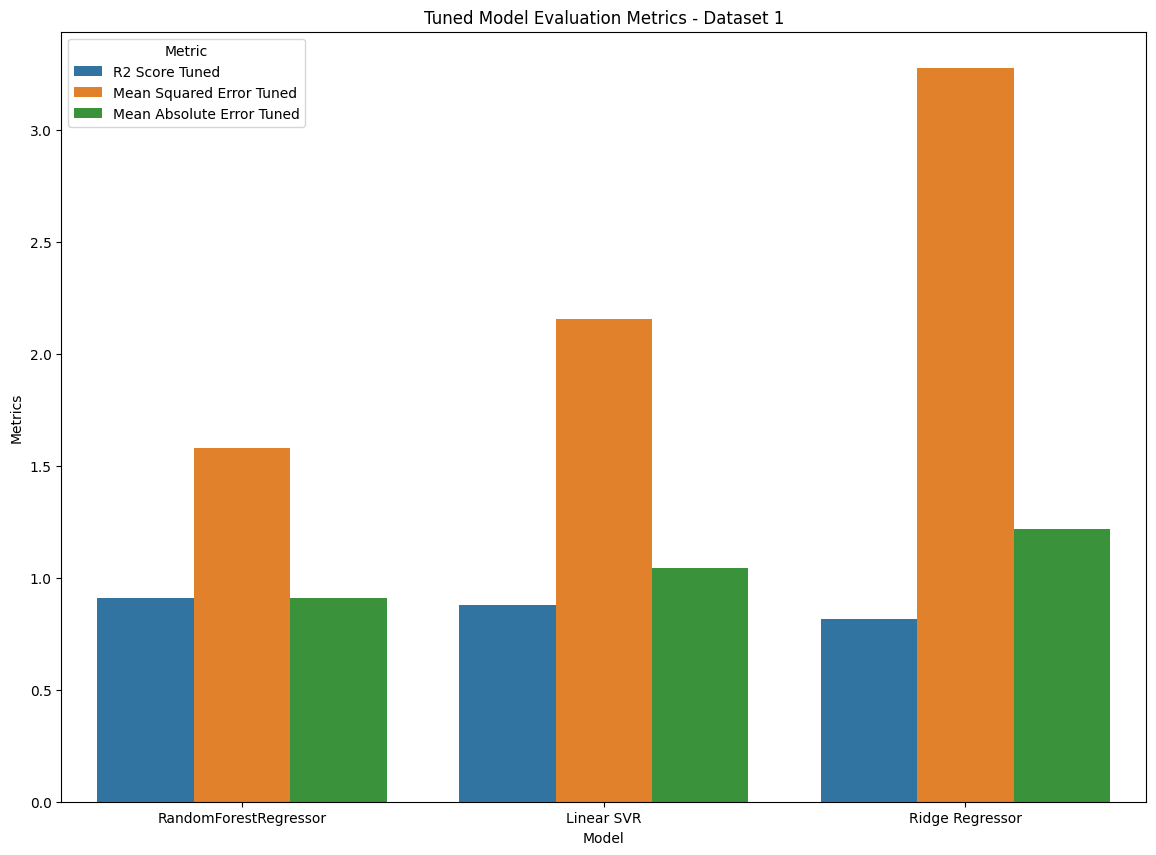

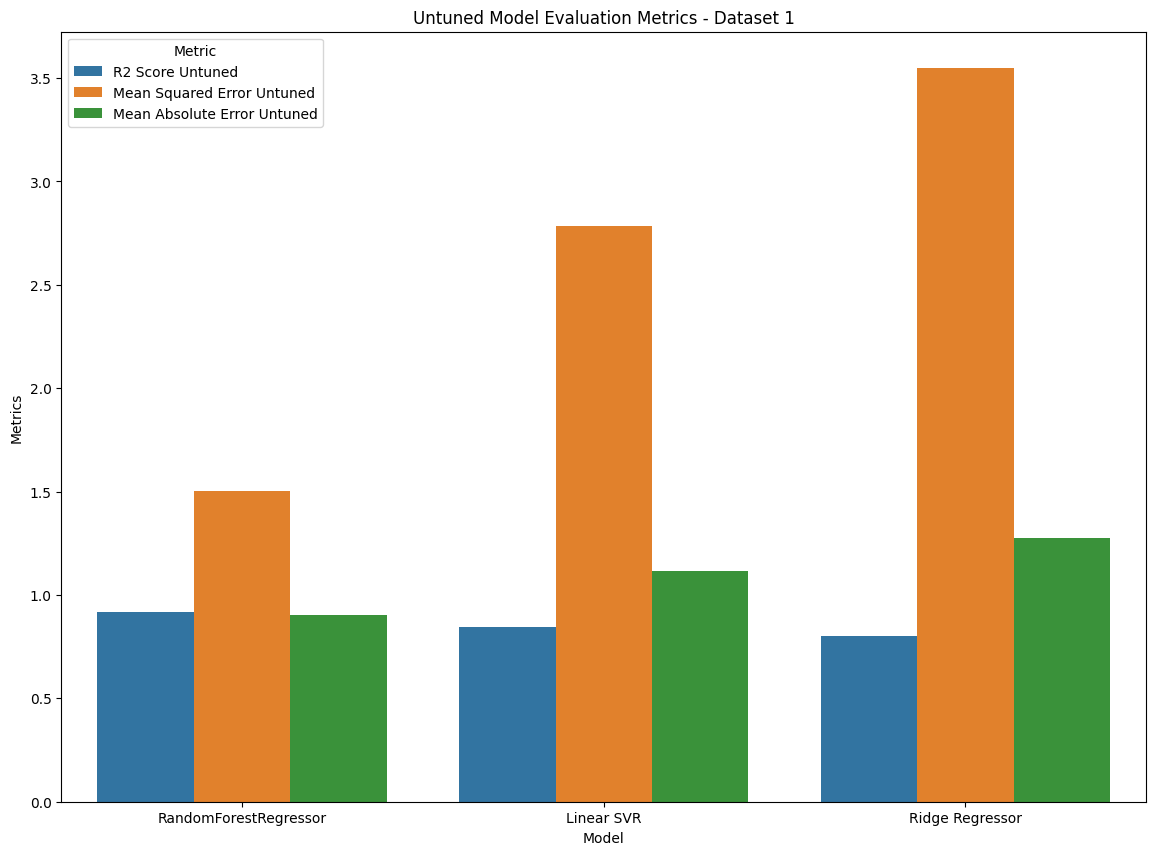

In [8]:
import seaborn as sns



# Melt the DataFrame to make it suitable for seaborn's bar plot
melted_results_tuned = pd.melt(results_df1, id_vars=['Model'],
                               value_vars=['R2 Score Tuned', 'Mean Squared Error Tuned', 'Mean Absolute Error Tuned'],
                               var_name='Metric', value_name='Value')

melted_results_untuned = pd.melt(results_df1, id_vars=['Model'],
                                 value_vars=['R2 Score Untuned', 'Mean Squared Error Untuned', 'Mean Absolute Error Untuned'],
                                 var_name='Metric', value_name='Value')

# Create a grouped bar plot for tuned results
plt.figure(figsize=(14, 10))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_results_tuned)
plt.title('Tuned Model Evaluation Metrics - Dataset 1')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.legend(title='Metric')
plt.show()

# Create a grouped bar plot for untuned results
plt.figure(figsize=(14, 10))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_results_untuned)
plt.title('Untuned Model Evaluation Metrics - Dataset 1')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.legend(title='Metric')
plt.show()
